# Current segmentation procedure

Here we show examples of applying the current segmentation procedure. We provide step-by-step instructions for the first examples (Spiker). 

**Note:** we recommend restarting the kernel when running each new example.

## Synthetic examples

In [1]:
from act.cell_model import ACTCellModel
from act.simulator import ACTSimulator
from act.segregation import ACTSegregator
from act.types import SimulationParameters, ConstantCurrentInjection

import matplotlib.pyplot as plt
import numpy as np

### Spiker

Classic Hodgkin-Huxely-based Spiker model.

Parameters:
- Cm = 1
- gnabar = .12 (S/cm2)
- gkbar = .036 (S/cm2)
- gl = .0003 (S/cm2)
- el = -54.3 (mV)

Modules:
- Spiking: [gnabar, gkbar]

**Step 1: Identify functional modules**

The spiker model has only 2 modules:
- Passive (includes only the leak channel, so no action needed).
- Spiking (Na and Kdr channels).

**Step 2: Set the activation functions**

Transfer the activation functions from the modfiles and plot them. We additionally plot e-leak for reference.

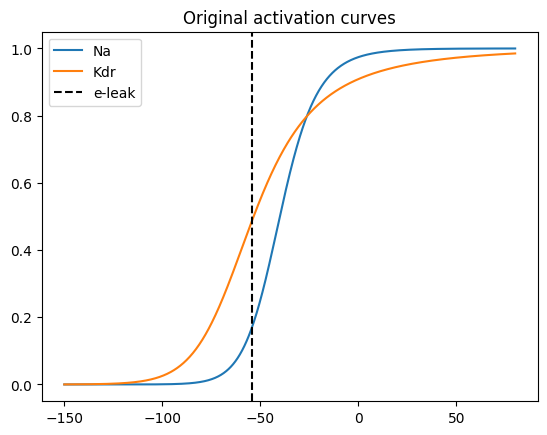

In [17]:
# From ACT/data/Spiker/orig/modfiles/hh.mod
def vtrap(x,y):
    if np.any(np.abs(x/y) < 1e-6):
        vtrap = y * (1 - x/y/2)
    else:
        vtrap = x / (np.exp(x/y) - 1)
    return vtrap

def Na(v):
    aNa = 0.1 * vtrap(-(v + 40), 10)
    bNa =  4 * np.exp(-(v + 65) / 18)
    return aNa / (aNa + bNa)

def Kdr(v):
    aK = 0.01 * vtrap(-(v + 55),10)
    bK = 0.125 * np.exp(-(v + 65) / 80)
    return aK / (aK + bK)

v = np.linspace(-150, 80, 1000)

plt.plot(v, Na(v), label = 'Na')
plt.plot(v, Kdr(v), label = 'Kdr')
plt.title("Original activation curves")
plt.axvline(-54.3, color = 'black', ls = '--', label = "e-leak")
plt.legend()

The segmentation procedure is implemented in the `ACTSegregator` module. It outputs segmented activation functions together with the text to update the modfiles. The procedure requires the specification of 2 parameters:
- `cutoff_v`: the left (right for the H channel) bound of the module.
- `extrapolate_dv`: the length of the linear extrapolation segment.

In [ ]:
segregator = ACTSegregator() 
seg_Na, seg_Kdr = segregator.segregate(v = v, activation_curves = [Na(v), Kdr(v)], cutoff_v = -54.3, extrapolate_dv = 2)

Update the modfiles with the following:
----------
Activation curve 0:

        :Segregation
        if (v < -52.3) {
        replace_with_var_name = 0.102 * v + 5.512
        }
        if (v < -54.3) {
        replace_with_var_name = 0
        }
        
----------
Activation curve 1:

        :Segregation
        if (v < -52.3) {
        replace_with_var_name = 0.258 * v + 14.0
        }
        if (v < -54.3) {
        replace_with_var_name = 0
        }
        


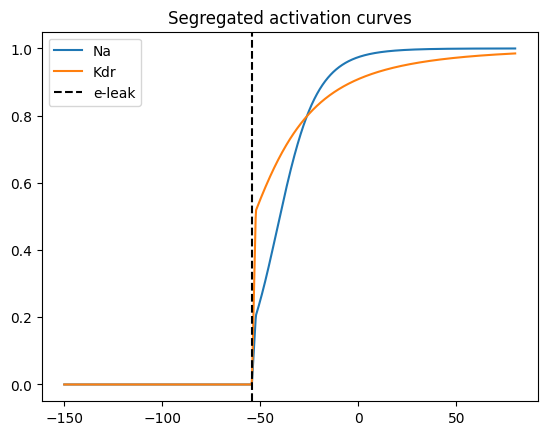

In [19]:
plt.plot(v, seg_Na, label = 'Na')
plt.plot(v, seg_Kdr, label = 'Kdr')
plt.title("Segregated activation curves")
plt.axvline(-54.3, color = 'black', ls = '--', label = "e-leak")
plt.legend()

**Step 3.** Make a copy of the original folder with simulation templates and modfiles and name it `seg`. Update the modfile with the segregator's output. Now we simulate the original and segmented cells.

In [10]:
orig_cell = ACTCellModel(
    cell_name = "Spiker",
    path_to_hoc_file = "data/Spiker/orig/target_template.hoc",
    path_to_mod_files = "data/Spiker/orig/modfiles/",
    passive = ["gl", "el", None],
    active_channels = ["hh_spiker.gnabar", "hh_spiker.gkbar"],
)

simulator = ACTSimulator(output_folder_name = "output")
simulator.submit_job(orig_cell, 
                     SimulationParameters(
                         sim_name = "spiker_orig", 
                         sim_idx = 1, 
                         h_celsius = 6.3, 
                         CI = [ConstantCurrentInjection(amp = 0.1, dur = 200, delay = 100)])
                    )
simulator.run_jobs(1)


        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


In [20]:
seg_cell = ACTCellModel(
    cell_name = "Spiker",
    path_to_hoc_file = "data/Spiker/orig/target_template.hoc",
    path_to_mod_files = "data/Spiker/seg/modfiles/",
    passive = ["gl", "el", None],
    active_channels = ["hh_spiker.gnabar", "hh_spiker.gkbar"],
)

simulator = ACTSimulator(output_folder_name = "output")
simulator.submit_job(seg_cell, 
                     SimulationParameters(
                         sim_name = "spiker_seg", 
                         sim_idx = 1, 
                         h_celsius = 6.3, 
                         CI = [ConstantCurrentInjection(amp = 0.1, dur = 200, delay = 100)])
                    )
simulator.run_jobs(1)


        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


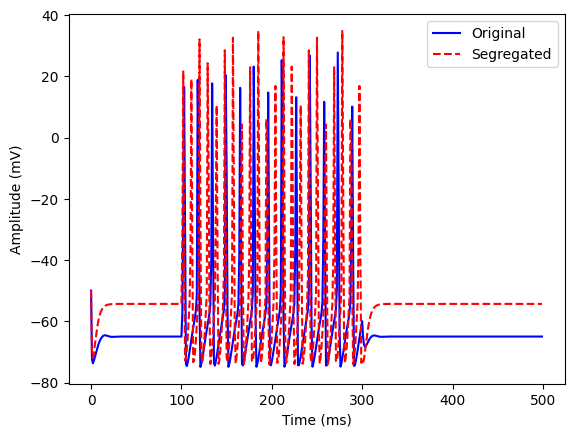

In [21]:
orig_out = np.load("output/spiker_orig/out_1.npy")
seg_out = np.load("output/spiker_seg/out_1.npy")

plt.plot(orig_out[::10, 0], label = "Original", c = 'blue')
plt.plot(seg_out[::10, 0], label = "Segregated", ls = '--', c = 'red')
plt.ylabel("Amplitude (mV)")
plt.xlabel("Time (ms)")
plt.legend()

### BursterCa

Ca-based burster.

Parameters:
- eleak = -50
- gbar_leak = 4e-05
- gbar_na = 0.13
- gbar_kdr = 0.1
- gbar_cas = 0.01
- gbar_ka = 0.17
- gbar_cat = 0.005

Modules:
- Bursting: [gbar_cas, gbar_ka, gbar_cat]
- Spiking: [gnabar, gkbar]

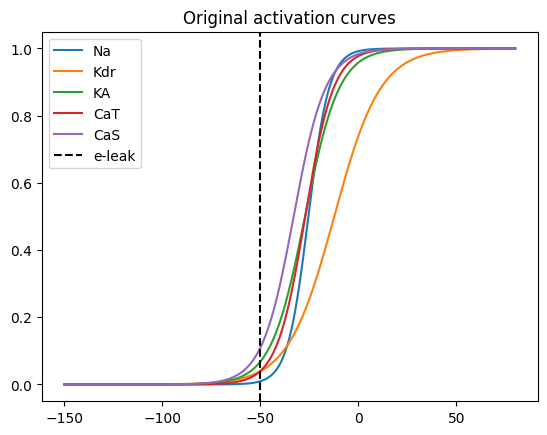

In [2]:
def Na(v):
    return 1.0/(1.0+ (np.exp((v+25.5)/(-5.29))))

def Kdr(v):
    return 1.0/(1.0 + (np.exp((v+12.3)/(-11.8))))

def KA(v):
    return 1.0/(1.0+(np.exp((v+27.2)/(-8.7))))

def CaT(v):
    return 1.0/(1.0+ (np.exp((v+27.1)/(-7.2))))

def CaS(v):
    return (1.0)/(1+ (np.exp((v+33.0)/(-8.1))))

v = np.linspace(-150, 80, 1000)

for func, func_name in zip([Na, Kdr, KA, CaT, CaS], ["Na", "Kdr", "KA", "CaT", "CaS"]):
    plt.plot(v, func(v), label = func_name)

plt.title("Original activation curves")
plt.axvline(-50, color = 'black', ls = '--', label = "e-leak")
plt.legend()

In [3]:
segregator = ACTSegregator()

segregated_bursting = segregator.segregate(v = v, activation_curves = [KA(v), CaT(v), CaS(v)], cutoff_v = -50)

Update the modfiles with the following:
----------
Activation curve 0:

        :Segregation
        if (v < -48) {
        replace_with_var_name = 0.042 * v + 2.095
        }
        if (v < -50) {
        replace_with_var_name = 0
        }
        
----------
Activation curve 1:

        :Segregation
        if (v < -48) {
        replace_with_var_name = 0.026 * v + 1.299
        }
        if (v < -50) {
        replace_with_var_name = 0
        }
        
----------
Activation curve 2:

        :Segregation
        if (v < -48) {
        replace_with_var_name = 0.068 * v + 3.388
        }
        if (v < -50) {
        replace_with_var_name = 0
        }
        


In [4]:
segregated_spiking = segregator.segregate(v = v, activation_curves = [Na(v), Kdr(v)], cutoff_v = -40)

Update the modfiles with the following:
----------
Activation curve 0:

        :Segregation
        if (v < -38) {
        replace_with_var_name = 0.042 * v + 1.689
        }
        if (v < -40) {
        replace_with_var_name = 0
        }
        
----------
Activation curve 1:

        :Segregation
        if (v < -38) {
        replace_with_var_name = 0.05 * v + 2.018
        }
        if (v < -40) {
        replace_with_var_name = 0
        }
        


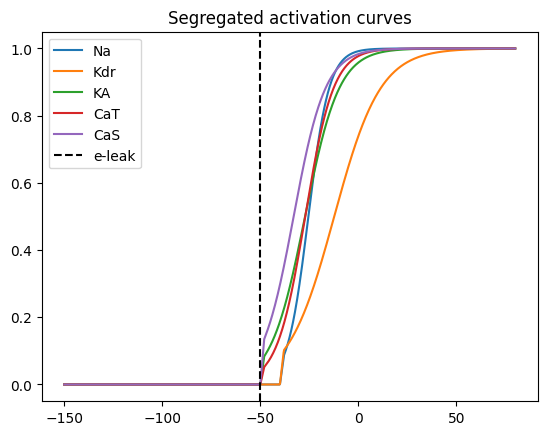

In [5]:
for ac, ac_name in zip(segregated_spiking, ["Na", "Kdr"]):
    plt.plot(v, ac, label = ac_name)
for ac, ac_name in zip(segregated_bursting, ["KA", "CaT", "CaS"]):
    plt.plot(v, ac, label = ac_name)

plt.title("Segregated activation curves")
plt.axvline(-50, color = 'black', ls = '--', label = "e-leak")
plt.legend()

In [ ]:
orig_cell = ACTCellModel(
    cell_name = "BursterCa",
    path_to_hoc_file = "data/BursterCa/orig/target_template.hoc",
    path_to_mod_files = "data/BursterCa/orig/modfiles/",
    passive = ["gbar_leak", "eleak", None],
    active_channels = ["gbar_na", "gbar_kdr", "gbar_ka", "gbar_cat", "gbar_cas"]
)

simulator = ACTSimulator(output_folder_name = "output")
simulator.submit_job(
    orig_cell, 
    SimulationParameters(
        sim_name = "burster_orig", 
        sim_idx = 1, 
        h_celsius = 37, 
        CI = [ConstantCurrentInjection(amp = 0.1, dur = 200, delay = 100)])
)
simulator.run_jobs(1)


        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


In [ ]:
seg_cell = ACTCellModel(
    cell_name = "BursterCa",
    path_to_hoc_file = "data/BursterCa/orig/target_template.hoc",
    path_to_mod_files = "data/BursterCa/seg/modfiles/",
    passive = ["gbar_leak", "eleak", None],
    active_channels = ["gbar_na", "gbar_kdr", "gbar_ka", "gbar_cat", "gbar_cas"]
)

simulator = ACTSimulator(output_folder_name = "output")
simulator.submit_job(
    seg_cell, 
    SimulationParameters(
        sim_name = "burster_seg", 
        sim_idx = 1,
        h_celsius = 37, 
        CI = [ConstantCurrentInjection(amp = 0.1, dur = 200, delay = 100)])
)
simulator.run_jobs(1)


        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


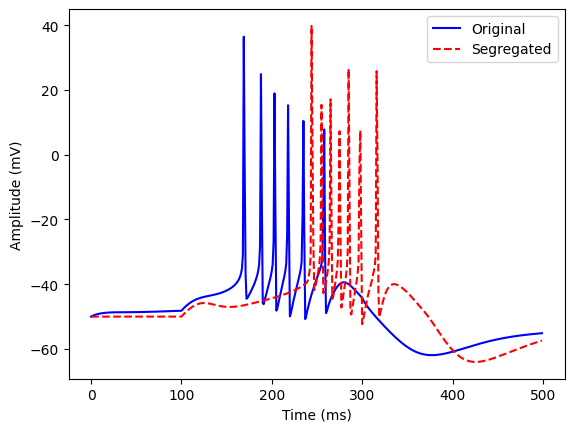

In [36]:
orig_out = np.load("output/burster_orig/out_1.npy")
seg_out = np.load("output/burster_seg/out_1.npy")

plt.plot(orig_out[::10, 0], label = "Original", c = 'blue')
plt.plot(seg_out[::10, 0], label = "Segregated", ls = '--', c = 'red')
plt.ylabel("Amplitude (mV)")
plt.xlabel("Time (ms)")
plt.legend()

### LA-A Cell

Parameters:
- el_leak = -70
- glbar_leak = 3.5e-5
- ghdbar_hd=2.3e-05
- gbar_na3=0.03
- gkdrbar_kdr=0.003
- gbar_nap= 0.0003
- gmbar_im = 0.002
- gkabar_kap = 0.000843
- gcabar_cadyn = 6e-5
- gsAHPbar_sAHP = 0.009

Modules:
- Passive: [h]
- LTO: [NaP, KM]
- Spiking: [Na3, Kdr]
- Bursting: [KA, Ca]

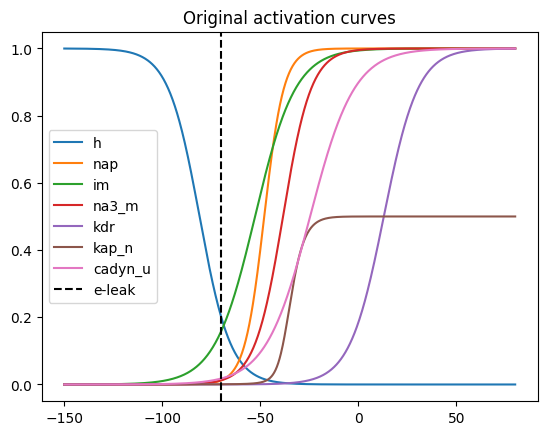

In [ ]:
def vtrap(x, y):
    if np.any(np.abs(x / y) < 1e-6):
        return y * (1 - x / y / 2)
    else:
        return x / (np.exp(x / y) - 1)

#CADYN
def cadyn_u(v):
    return 1/(np.exp(-(v+24.6)/11.3)+1)

#H
def h(v):
    return 1/(1 + np.exp(-(v+81)/-8))

#IM
def im(v):
    return 1 / ( 1 + np.exp( ( - v - 52.7 ) / 10.34 ) )

#KAP

def kap_n(v):
    zeta=-2.5/(1+np.exp((v+40)/5))
    alpn = np.exp(1.e-3*zeta*(v-11)*9.648e4/(8.315*(273.16+31))) 
    return 1/(1 + alpn)

#KDR
def kdr(v):
    return 1 / ( 1 + np.exp( ( - v + 13 ) / 8.738 ) )

#NA3
def na3_m(v):
    return 1 / ( 1 + np.exp( ( - v - 38.43 ) / 7.2 ) )

#NAP
def nap(v):
    return 1 / ( 1 + np.exp( ( - v - 48 ) / 5 ) )

v = np.linspace(-150, 80, 1000)

for func, func_name in zip([h, nap, im, na3_m, kdr, kap_n, cadyn_u], ["h", "nap", "im", "na3_m", "kdr", "kap_n", "cadyn_u"]):
    plt.plot(v, func(v), label = func_name)

plt.title("Original activation curves")
plt.axvline(-70, color = 'black', ls = '--', label = "e-leak")
plt.legend()


In [14]:
segregator = ACTSegregator()

segregated_passive = segregator.segregate(v = v, activation_curves = [h(v)], cutoff_v = -70)
segregated_lto = segregator.segregate(v = v, activation_curves = [nap(v), im(v)], cutoff_v = -70)
segregated_spiking = segregator.segregate(v = v, activation_curves = [na3_m(v), kdr(v)], cutoff_v = -60)
segregated_bursting = segregator.segregate(v = v, activation_curves = [kap_n(v), cadyn_u(v)], cutoff_v = -40)

Update the modfiles with the following:
----------
Activation curve 0:

        :Segregation
        if (v > -72) {
        replace_with_var_name = -0.122 * v + -8.539
        }
        if (v > -70) {
        replace_with_var_name = 0
        }
        
Update the modfiles with the following:
----------
Activation curve 0:

        :Segregation
        if (v < -68) {
        replace_with_var_name = 0.009 * v + 0.625
        }
        if (v < -70) {
        replace_with_var_name = 0
        }
        
----------
Activation curve 1:

        :Segregation
        if (v < -68) {
        replace_with_var_name = 0.092 * v + 6.472
        }
        if (v < -70) {
        replace_with_var_name = 0
        }
        
Update the modfiles with the following:
----------
Activation curve 0:

        :Segregation
        if (v < -58) {
        replace_with_var_name = 0.03 * v + 1.824
        }
        if (v < -60) {
        replace_with_var_name = 0
        }
        
----------
Activation curve 1:


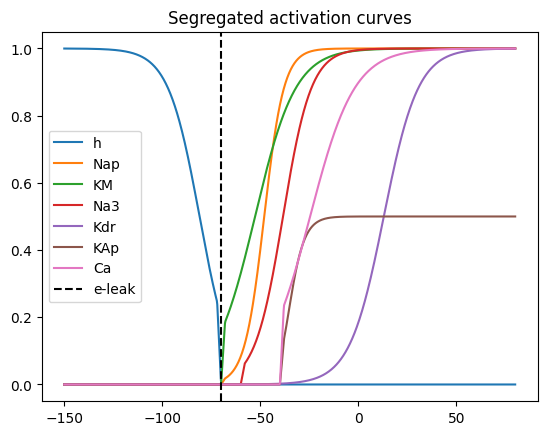

In [15]:
for ac, ac_name in zip(segregated_passive, ["h"]):
    plt.plot(v, ac, label = ac_name)
for ac, ac_name in zip(segregated_lto, ["Nap", "KM"]):
    plt.plot(v, ac, label = ac_name)
for ac, ac_name in zip(segregated_spiking, ["Na3", "Kdr"]):
    plt.plot(v, ac, label = ac_name)
for ac, ac_name in zip(segregated_bursting, ["KAp", "Ca"]):
    plt.plot(v, ac, label = ac_name)

plt.title("Segregated activation curves")
plt.axvline(-70, color = 'black', ls = '--', label = "e-leak")
plt.legend()

In [17]:
orig_cell = ACTCellModel(
    cell_name = "Cell_A",
    path_to_hoc_file = "data/LAA/orig/target_template.hoc",
    path_to_mod_files = "data/LAA/orig/modfiles/",
    passive = ["glbar_leak", "el_leak", "ghdbar_hd"],
    active_channels = ["gbar_nap", "gmbar_im", "gbar_na3", "gkdrbar_kdr", "gkabar_kap", "gcabar_cadyn"]
)

simulator = ACTSimulator(output_folder_name = "output")
simulator.submit_job(
    orig_cell, 
    SimulationParameters(
        sim_name = "LAA_orig", 
        sim_idx = 1, 
        h_celsius = 37, 
        CI = [ConstantCurrentInjection(amp = 0.1, dur = 200, delay = 100)])
)
simulator.run_jobs(1)


        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


In [18]:
seg_cell = ACTCellModel(
    cell_name = "Cell_A",
    path_to_hoc_file = "data/LAA/orig/target_template.hoc",
    path_to_mod_files = "data/LAA/seg/modfiles/",
    passive = ["glbar_leak", "el_leak", "ghdbar_hd"],
    active_channels = ["gbar_nap", "gmbar_im", "gbar_na3", "gkdrbar_kdr", "gkabar_kap", "gcabar_cadyn"]
)

simulator = ACTSimulator(output_folder_name = "output")
simulator.submit_job(
    seg_cell, 
    SimulationParameters(
        sim_name = "LAA_seg", 
        sim_idx = 1,
        h_celsius = 37, 
        CI = [ConstantCurrentInjection(amp = 0.1, dur = 200, delay = 100)])
)
simulator.run_jobs(1)


        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


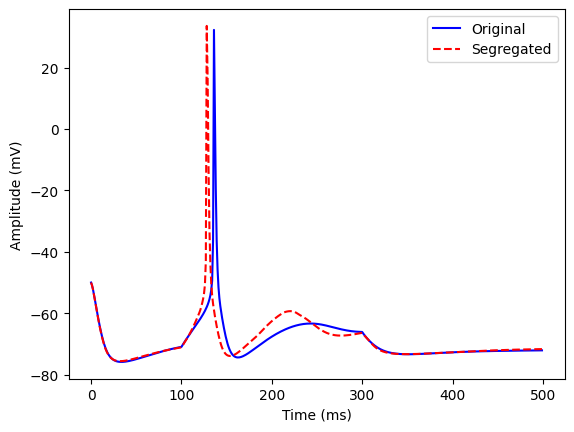

In [20]:
orig_out = np.load("output/LAA_orig/out_1.npy")
seg_out = np.load("output/LAA_seg/out_1.npy")

plt.plot(orig_out[::10, 0], label = "Original", c = 'blue')
plt.plot(seg_out[::10, 0], label = "Segregated", ls = '--', c = 'red')
plt.ylabel("Amplitude (mV)")
plt.xlabel("Time (ms)")
plt.legend()

## Realistic examples

### SST & L5 Cells (Allen Database) – modfiles are shared

A [Layer 2/3 SST cell](http://celltypes.brain-map.org/mouse/experiment/electrophysiology/476686112) and a [Layer 5 cell](https://celltypes.brain-map.org/experiment/electrophysiology/480351780) from the mouse primary visual area.

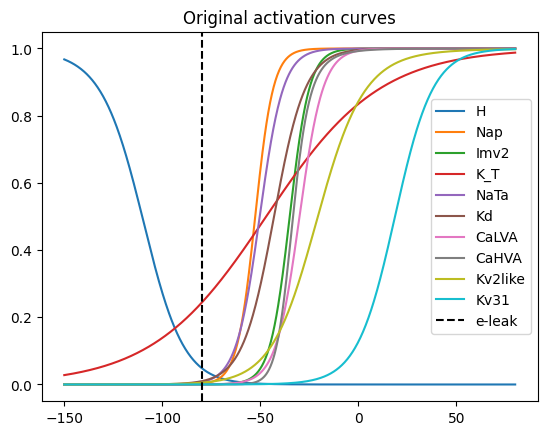

In [15]:
def vtrap(x, y):
    if np.any(np.abs(x / y) < 1e-6):
        return y * (1 - x / y / 2)
    else:
        return x / (np.exp(x / y) - 1)

def H(v):
    mAlpha = 0.001 * 6.43 * vtrap(v + 154.9, 11.9)
    mBeta  =  0.001*193*np.exp(v/33.1)
    return mAlpha/(mAlpha + mBeta)

def NaTa(v):
    malphaF = 0.182
    mbetaF = 0.124
    mvhalf = -48
    mk = 6
    mAlpha = malphaF * vtrap(-(v - mvhalf), mk)
    mBeta = mbetaF * vtrap((v - mvhalf), mk)
    mInf = mAlpha/(mAlpha + mBeta)
    return mInf

def Nap(v):
    return 1.0/(1+np.exp((v- -52.6)/-4.6))

def Kd(v):
    return 1 - 1 / (1 + np.exp((v - (-43)) / 8))

def Kv2like(v):
    mAlpha = 0.12 * vtrap( -(v - 43), 11.0)
    mBeta = 0.02 * np.exp(-(v + 1.27) / 120)
    return mAlpha/(mAlpha + mBeta)

def Kv31(v):
    return 1/(1+np.exp(((v -(18.700 + 0))/(-9.700))))

def K_T(v): # Transient potassium
    return 1/(1 + np.exp(-(v - (-47 + 0)) / 29))

def Imv2(v):
    mAlpha = 3.3e-3*np.exp(2.5*0.04*(v - -35))
    mBeta = 3.3e-3*np.exp(-2.5*0.04*(v - -35))
    return mAlpha/(mAlpha + mBeta)

# SK is purely Ca-dependent, skipping
def CaHVA(v):
    mAlpha = 0.055 * vtrap(-27 - v, 3.8)
    mBeta  =  (0.94*np.exp((-75-v)/17))
    return mAlpha/(mAlpha + mBeta)

def CaLVA(v):
    return 1.0000/(1+ np.exp((v - -30.000)/-6))

v = np.linspace(-150, 80, 1000)

for func, func_name in zip([H, Nap, Imv2, K_T, NaTa, Kd, CaLVA, CaHVA, Kv2like, Kv31], ["H", "Nap", "Imv2", "K_T", "NaTa", "Kd", "CaLVA", "CaHVA", "Kv2like", "Kv31"]):
    plt.plot(v, func(v), label = func_name)

plt.title("Original activation curves")
plt.axvline(-79.66, color = 'black', ls = '--', label = "e-leak")
plt.legend()

In [12]:
segregator = ACTSegregator()
segregated_passive = segregator.segregate(v, [H(v)], cutoff_v = -79.66)
segregated_lto = segregator.segregate(v = v, activation_curves = [Nap(v), Imv2(v), K_T(v)], cutoff_v = -79.66)
segregated_spiking = segregator.segregate(v = v, activation_curves = [NaTa(v), Kd(v)], cutoff_v = -60)
segregated_bursting = segregator.segregate(v = v, activation_curves = [CaLVA(v), CaHVA(v), Kv2like(v), Kv31(v)], cutoff_v = -40)

Update the modfiles with the following:
----------
Activation curve 0:

        :Segregation
        if (v > -81.66) {
        replace_with_var_name = -0.029 * v + -2.289
        }
        if (v > -79.66) {
        replace_with_var_name = 0
        }
        
Update the modfiles with the following:
----------
Activation curve 0:

        :Segregation
        if (v < -77.66) {
        replace_with_var_name = 0.002 * v + 0.169
        }
        if (v < -79.66) {
        replace_with_var_name = 0
        }
        
----------
Activation curve 1:

        :Segregation
        if (v < -77.66) {
        replace_with_var_name = 0.0 * v + 0.008
        }
        if (v < -79.66) {
        replace_with_var_name = 0
        }
        
----------
Activation curve 2:

        :Segregation
        if (v < -77.66) {
        replace_with_var_name = 0.129 * v + 10.257
        }
        if (v < -79.66) {
        replace_with_var_name = 0
        }
        
Update the modfiles with the following:
-------

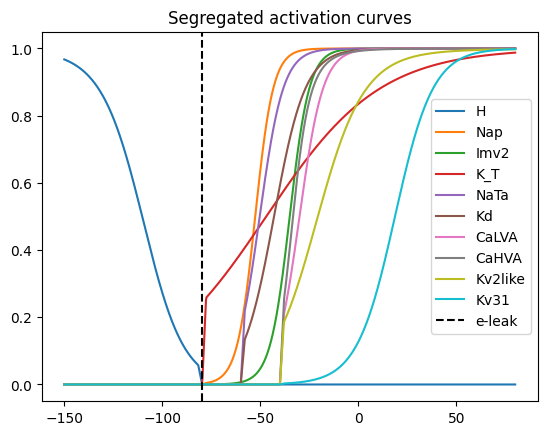

In [13]:
for ac, ac_name in zip(segregated_passive, ["H"]):
    plt.plot(v, ac, label = ac_name)

for ac, ac_name in zip(segregated_lto, ["Nap", "Imv2", "K_T"]):
    plt.plot(v, ac, label = ac_name)    

for ac, ac_name in zip(segregated_spiking, ["NaTa", "Kd"]):
    plt.plot(v, ac, label = ac_name)

for ac, ac_name in zip(segregated_bursting, ["CaLVA", "CaHVA", "Kv2like", "Kv31"]):
    plt.plot(v, ac, label = ac_name)

plt.title("Segregated activation curves")
plt.axvline(-79.66, color = 'black', ls = '--', label = "e-leak")
plt.legend()

In [2]:
import sys
sys.path.append("data/SST")

# 3D morphology builder for the L5 cell
from cell_builder import sst_orig_cell_builder, sst_seg_cell_builder

In [3]:
orig_cell = ACTCellModel(
    cell_name = None,
    path_to_hoc_file = None,
    path_to_mod_files = "data/SST/orig/modfiles/",
    passive = ["g_pas", "e_pas", "gbar_Ih"],
    active_channels = ["gbar_Nap", "gbar_Im_v2", "gbar_K_T", "gbar_NaTa", "gbar_Kd", "gbar_Ca_LVA", "gbar_Ca_HVA", "gbar_Kv2like", "gbar_Kv3_1"]
)

orig_cell.set_custom_cell_builder(sst_orig_cell_builder)

simulator = ACTSimulator(output_folder_name = "output")
simulator.submit_job(
    orig_cell, 
    SimulationParameters(
        sim_name = "SST_orig", 
        sim_idx = 1, 
        h_celsius = 37, 
        CI = [ConstantCurrentInjection(amp = 0.1, dur = 200, delay = 100)])
)
simulator.run_jobs(1)


        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        
warning ./Sst-IRES-Cre_Ai14-188740.03.02.01_657210399_m.swc: more than one tree:
  root at line 4
  root at line 14504
  root at line 14725
  root at line 14798
  root at line 15141
  root at line 15144
  root at line 15156
  root at line 15211
  root at line 15318
  root at line 15496
  root at line 15811
  root at line 15857
  root at line 15883
  root at line 16161
  root at line 16200
  root at line 16210
  root at line 16253
  root at line 16286
  root at line 16301
  root at line 16326
  root at line 16574
  root at line 16613
  root at line 16618
  root at line 16645
  root at line 16695
  root at line 16751
  root at line 16765
  root at line 16768


In [5]:
seg_cell = ACTCellModel(
    cell_name = None,
    path_to_hoc_file = None,
    path_to_mod_files = "data/SST/seg/modfiles/",
    passive = ["g_pas", "e_pas", "gbar_Ih"],
    active_channels = ["gbar_Nap", "gbar_Im_v2", "gbar_K_T", "gbar_NaTa", "gbar_Kd", "gbar_Ca_LVA", "gbar_Ca_HVA", "gbar_Kv2like", "gbar_Kv3_1"]
)

seg_cell.set_custom_cell_builder(sst_seg_cell_builder)

simulator = ACTSimulator(output_folder_name = "output")
simulator.submit_job(
    seg_cell, 
    SimulationParameters(
        sim_name = "SST_seg", 
        sim_idx = 1, 
        h_celsius = 37, 
        CI = [ConstantCurrentInjection(amp = 0.1, dur = 200, delay = 100)])
)
simulator.run_jobs(1)


        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        
warning ./Sst-IRES-Cre_Ai14-188740.03.02.01_657210399_m.swc: more than one tree:
  root at line 4
  root at line 14504
  root at line 14725
  root at line 14798
  root at line 15141
  root at line 15144
  root at line 15156
  root at line 15211
  root at line 15318
  root at line 15496
  root at line 15811
  root at line 15857
  root at line 15883
  root at line 16161
  root at line 16200
  root at line 16210
  root at line 16253
  root at line 16286
  root at line 16301
  root at line 16326
  root at line 16574
  root at line 16613
  root at line 16618
  root at line 16645
  root at line 16695
  root at line 16751
  root at line 16765
  root at line 16768


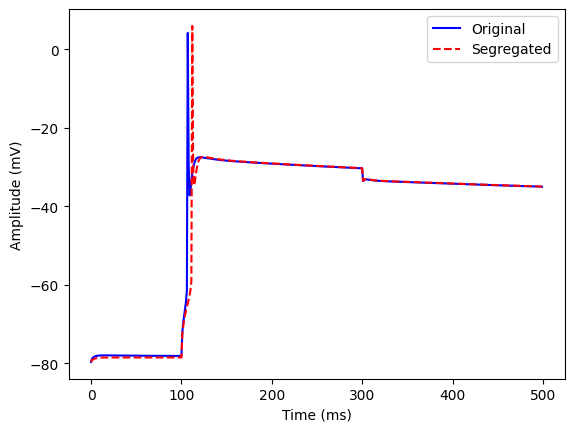

In [8]:
orig_out = np.load("output/SST_orig/out_1.npy")[::10, 0]
seg_out = np.load("output/SST_seg/out_1.npy")[::10, 0]

plt.plot(orig_out, label = "Original", c = 'blue')
plt.plot(seg_out, label = "Segregated", ls = '--', c = 'red')
plt.ylabel("Amplitude (mV)")
plt.xlabel("Time (ms)")
plt.legend()